In [1]:
# https://dev.socrata.com/foundry/data.cityofnewyork.us/uwyp-dntv
# pip install sodapy
# HAS TO BE PYTHON 3

import pandas as pd
from sodapy import Socrata
import matplotlib.pyplot as plt
import matplotlib as mpl
import osmnx as ox
import networkx as nx
import numpy as np
import pygsp as pg
import time

import sys
sys.path.append('../GTF3')
from admm import admm
from Utilities import *

# incrase timeout if you get ReadTimeoutError
client = Socrata("data.cityofnewyork.us", "HN063rrTWrFktKEhX2AeMqfXG", timeout=30)


In [2]:
def get_searchstr(datestr, lats, longs, pickup):
    if pickup:
        print("Pickup")
        wherestr = "(tpep_pickup_datetime between '"+datestr[0]+"' and '"+datestr[1]+"') AND (pickup_latitude between "+lats[0]+" and "+lats[1]+") AND (pickup_longitude between "+longs[0]+" and "+longs[1]+")"
        selectstr = "tpep_pickup_datetime,pickup_longitude,pickup_latitude"
        orderstr = "tpep_pickup_datetime"
    else:
        print("Dropoff")
        wherestr = "(dropoff_datetime between '"+datestr[0]+"' and '"+datestr[1]+"') AND (dropoff_latitude between "+lats[0]+" and "+lats[1]+") AND (dropoff_longitude between "+longs[0]+" and "+longs[1]+")"
        selectstr = "dropoff_datetime,dropoff_longitude,dropoff_latitude"
        orderstr = "dropoff_datetime"

    print("Requesting: ", wherestr)
    return (wherestr, selectstr, orderstr)

def cast_df(res, pickup):
    res = pd.DataFrame.from_records(res)
    if pickup:
        res = res.astype({'pickup_longitude': 'float64','pickup_latitude': 'float64'})
    else:
        res = res.astype({'dropoff_longitude': 'float64','dropoff_latitude': 'float64'})
    return res

def get_data(datestr, lats, longs, limit=100, offset=0, pickup=True):
    wherestr, selectstr, orderstr = get_searchstr(datestr, lats, longs, pickup)

    results = client.get("uwyp-dntv", where=wherestr, select=selectstr, order=orderstr, limit=limit, offset=offset)
    return cast_df(results, pickup)

def get_all_data(datestr, lats, longs, pickup=True):
    wherestr, selectstr, orderstr = get_searchstr(datestr, lats, longs, pickup)
    
    new_results = [0]
    results = []
    limit = 3000
    offset = 0
    
    while len(new_results) >0:
        new_results = client.get("uwyp-dntv", where=wherestr, select=selectstr, order=orderstr, limit=limit, offset=offset)
        offset += limit
        results += new_results
        print(str(offset)+" rows...")
            
    print("total "+str(len(results))+" rows")
    return cast_df(results, pickup)

In [3]:
def filter_off_island(df, pickup=True):
    if pickup:
        x = np.array(df.pickup_longitude.tolist())
        y = np.array(df.pickup_latitude.tolist())
    else:
        x = np.array(df.dropoff_longitude.tolist())
        y = np.array(df.dropoff_latitude.tolist())
        
    p1 = (-73.98, 40.705)
    p2 = (-73.9, 40.835)
    m1 = (p2[1]-p1[1])/(p2[0]-p1[0])

    p3 = (-74.02, 40.740)
    p4 = (-73.94, 40.87)
    m2 = (p4[1]-p3[1])/(p4[0]-p3[0])

    mask = (y-p1[1]>m1*(x-p1[0]))&(y-p3[1]<m2*(x-p3[0]))
    print(sum(mask))
    return df.iloc[mask]


def get_closest_nodes(G, df, pickup=True):
    if pickup:
        latitudes = df.pickup_latitude.values.tolist()
        longitudes = df.pickup_longitude.values.tolist()
    else:    
        latitudes = df.dropoff_latitude.values.tolist()
        longitudes = df.dropoff_longitude.values.tolist()
    return ox.utils.get_nearest_nodes(G = G, X = np.array(longitudes), Y = np.array(latitudes), method='kdtree')

def get_signal_dict(G, df):
    nodes = list(G.nodes)
    list_init =  [0.0] * G.number_of_nodes()
    dict_init = dict(zip(nodes, list_init))
    closest_nodes = df.closest_node.values.tolist()
    count_dict = dict((x,closest_nodes.count(x)) for x in set(closest_nodes))
    dict_init.update(count_dict)
    return dict_init.copy()

In [4]:
# use pygsp to plot pickups
from mpl_toolkits.axes_grid1 import make_axes_locatable

def get_pygsp_graph(G):
    x_coords =[ val[1] for val in list(G.nodes(data='x'))]
    y_coords =[ val[1] for val in list(G.nodes(data='y'))]
    coords = np.array(list(zip(x_coords,y_coords)))
    A = nx.to_numpy_matrix(G)
    G_pg = pg.graphs.Graph( W = A, coords = coords ) 
    return G_pg

def plot_nyc_signal(G_pg, sig, name, normalize=True, absolute=True, log=True, figsize=(10, 15), colorbar=False, limits=None):
    if normalize:
        sig = sig/np.linalg.norm(sig,2)
    if limits == None:
        print ([ min(sig),  max(sig)])
        print ([ min(abs(sig)),  max(abs(sig))])
        print ([ min(np.log10(abs(sig))),  max(np.log10(abs(sig)))])
        if absolute:
            sig = abs(sig)
        if log:
            sig = np.log10(abs(sig))
            limits = [1, 2.5]
        elif normalize:
            limits = [-0.08, 0.08]
        else:
            limits = [0, 400]
            
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    pg.plotting.plot_graph(G_pg, vertex_size=5, ax=ax, plot_name = "pickup+dropoffs: "+name)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    #ax.scatter(G_pg.coords[:,0], G_pg.coords[:,1], s=5, c=sig)
    #pg.plotting.plot_signal(G_pg, sig, highlight=[1], limits=limits, vertex_size=40, colorbar=True, plot_name = "pickup+dropoffs: "+name,ax = ax)

    ind = np.argsort(abs(sig))
    #cmap = mpl.cm.get_cmap('PuRd')
    cmap = mpl.cm.get_cmap('RdBu')
    #cmap = mpl.cm.get_cmap('RdYlBu')
    #cmap = mpl.cm.get_cmap('viridis')
    im = ax.scatter(G_pg.coords[ind,0], G_pg.coords[ind,1], s = 50, c=sig[ind], vmin=limits[0], vmax=limits[1], cmap=cmap, alpha =1, zorder=10)
    if colorbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')

def plot_nyc_raw_signal(G_pg, sig, coords, name, normalize=True, absolute=True, log=True, figsize=(10, 15), colorbar=False, limits=None):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    pg.plotting.plot_graph(G_pg, vertex_size=5, ax=ax, plot_name = name)
  #  ax.set_xticklabels([])
  #  ax.set_yticklabels([])
    #ax.scatter(G_pg.coords[:,0], G_pg.coords[:,1], s=5, c=sig)
    #pg.plotting.plot_signal(G_pg, sig, highlight=[1], limits=limits, vertex_size=40, colorbar=True, plot_name = "pickup+dropoffs: "+name,ax = ax)

    cmap = mpl.cm.get_cmap('PuRd')
    im = ax.scatter(coords[:,0], coords[:,1], s = 10, c=sig, vmin=limits[0], vmax=limits[1], cmap=cmap, alpha =1, zorder=10)
    if colorbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')

def plot_convergence(err_path, gamma, rho):
    plt.figure()
    plt.subplot(211)
    plt.plot(err_path[1], 'k', label='r norm')
    plt.plot(err_path[2], 'k--', label='eps_pri')
    plt.title(penalty_f+'. rho: '+str(rho)+' gamma: '+str(gamma))
    plt.ylabel(r'$||r||_2$')
    plt.legend()

    plt.subplot(212)
    plt.plot(err_path[3], 'k', label='s norm')
    plt.plot(err_path[4], 'k--', label='eps_dual')
    plt.ylabel(r'$||s||_2$')
    plt.xlabel('iterations')
    plt.legend()
    plt.show()

# Get graph

In [5]:
G = ox.graph_from_place('Manhattan Island, New York City, New York, USA', network_type='drive')
G = G.to_undirected()
G = nx.Graph(G)
tmp = G.selfloop_edges()
G.remove_edges_from(list(tmp))
print(G.number_of_selfloops())
print(G.number_of_nodes())
print(G.number_of_edges())
G_pg = get_pygsp_graph(G)

0
4496
7988


# Get event signal

In [6]:
event_time_start = '2011-06-26T12:00:00'
event_time_end = '2011-06-26T14:00:00'
#bbox_lats = ['40.725', '40.755']
#bbox_logs = ['-74.0180549', '-73.98']
bbox_lats = ['40.7014943', '40.8761912']
bbox_logs = ['-74.0180549', '-73.9112343']

pickup = get_all_data([event_time_start, event_time_end], bbox_lats, bbox_logs, pickup=True)
dropoff = get_all_data([event_time_start, event_time_end], bbox_lats, bbox_logs, pickup=False)

Pickup
Requesting:  (tpep_pickup_datetime between '2011-06-26T12:00:00' and '2011-06-26T14:00:00') AND (pickup_latitude between 40.7014943 and 40.8761912) AND (pickup_longitude between -74.0180549 and -73.9112343)
3000 rows...
6000 rows...
9000 rows...
12000 rows...
15000 rows...
18000 rows...
21000 rows...
24000 rows...
27000 rows...
30000 rows...
33000 rows...
36000 rows...
39000 rows...
42000 rows...
total 38496 rows
Dropoff
Requesting:  (dropoff_datetime between '2011-06-26T12:00:00' and '2011-06-26T14:00:00') AND (dropoff_latitude between 40.7014943 and 40.8761912) AND (dropoff_longitude between -74.0180549 and -73.9112343)
3000 rows...
6000 rows...
9000 rows...
12000 rows...
15000 rows...
18000 rows...
21000 rows...
24000 rows...
27000 rows...
30000 rows...
33000 rows...
36000 rows...
39000 rows...
42000 rows...
total 37346 rows


In [7]:
pickup = filter_off_island(pickup, True)
dropoff = filter_off_island(dropoff, False)

37931
36557


In [8]:
pickup['closest_node'] = get_closest_nodes(G, pickup, pickup=True)
dropoff['closest_node'] = get_closest_nodes(G, dropoff, pickup=False)

In [9]:
pickup_sig_event = get_signal_dict(G, pickup)
dropoff_sig_event = get_signal_dict(G, dropoff)
sig_dict = {key: pickup_sig_event[key] for key in pickup_sig_event.keys()}
sig_dict = {key: sig_dict[key] + dropoff_sig_event[key] for key in dropoff_sig_event.keys()}
nx.set_node_attributes(G,sig_dict,'sig_event')

# Plotting event signals

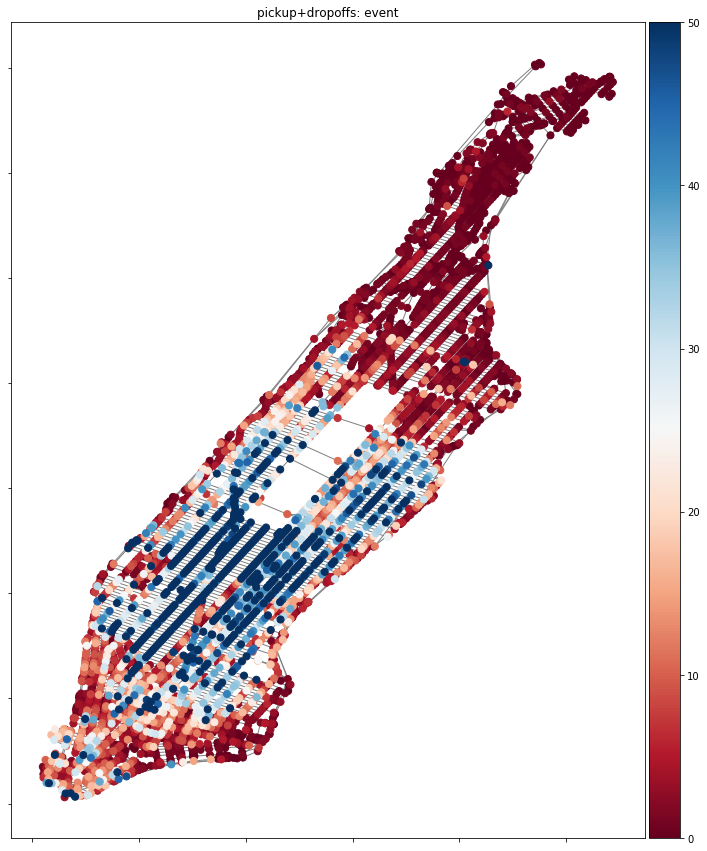

In [10]:
figsize = (12, 15)
logbool = False
sig_event = np.array(list(nx.get_node_attributes(G,'sig_event').values()))
plot_nyc_signal(G_pg, sig_event, name='event', normalize=False, absolute=False, log=logbool, figsize=figsize, limits=[0,50],colorbar=True)

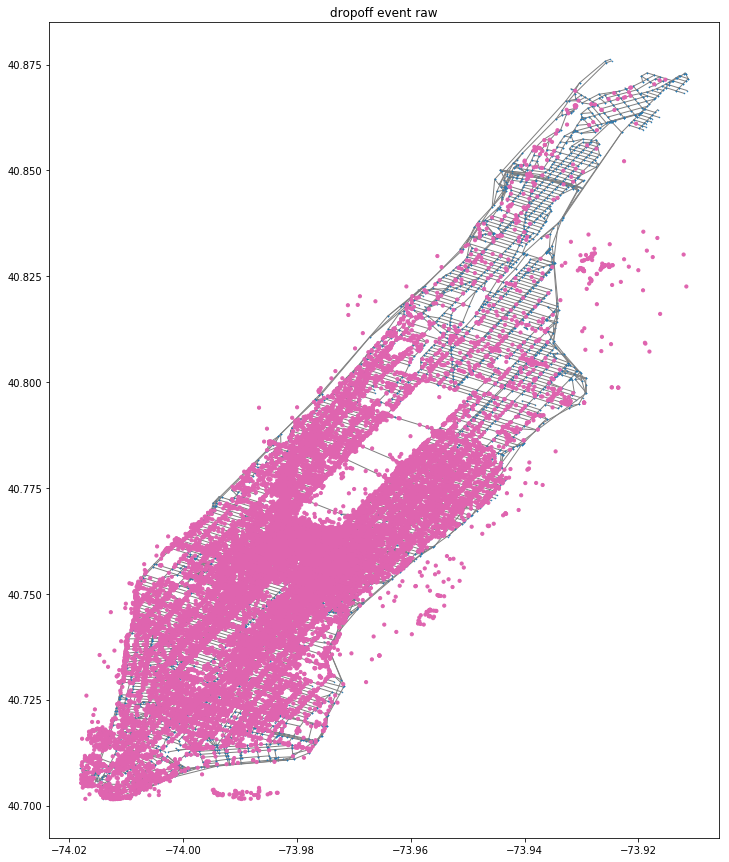

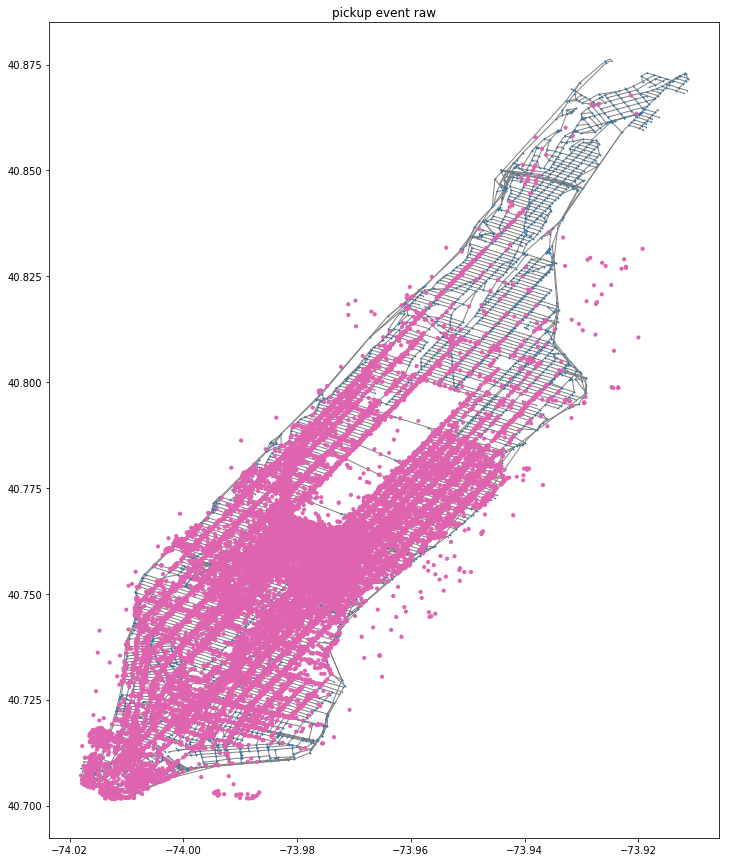

In [11]:
coords = np.array(dropoff[["dropoff_longitude", "dropoff_latitude"]])
plot_nyc_raw_signal(G_pg, len(dropoff.index)*[1], coords, name='dropoff event raw', normalize=False, absolute=False, log=logbool, figsize=figsize, limits=[0,2],colorbar=False)
coords = np.array(pickup[["pickup_longitude", "pickup_latitude"]])
plot_nyc_raw_signal(G_pg, len(pickup.index)*[1], coords, name='pickup event raw', normalize=False, absolute=False, log=logbool, figsize=figsize, limits=[0,2],colorbar=False)

# Get seasonal average signal

In [12]:
season_avg_dates = ['5-29','6-05','6-12','6-19','7-03','7-10','7-17','7-24']
season_time_start = ['2011-0'+elem+'T12:00:00' for elem in season_avg_dates]
season_time_end = ['2011-0'+elem+'T14:00:00' for elem in season_avg_dates]

for idx in range(len(season_avg_dates)):
    pickup = get_all_data([season_time_start[idx], season_time_end[idx]], bbox_lats, bbox_logs, pickup=True)
    dropoff = get_all_data([season_time_start[idx], season_time_end[idx]], bbox_lats, bbox_logs, pickup=False)
    if idx == 0:
        season_pickup = pickup
        season_dropoff = dropoff
    else:
        season_pickup = pd.concat([season_pickup, pickup])
        season_dropoff = pd.concat([season_dropoff, dropoff])

Pickup
Requesting:  (tpep_pickup_datetime between '2011-05-29T12:00:00' and '2011-05-29T14:00:00') AND (pickup_latitude between 40.7014943 and 40.8761912) AND (pickup_longitude between -74.0180549 and -73.9112343)
3000 rows...
6000 rows...
9000 rows...
12000 rows...
15000 rows...
18000 rows...
21000 rows...
24000 rows...
27000 rows...
30000 rows...
33000 rows...
36000 rows...
39000 rows...
42000 rows...
total 36190 rows
Dropoff
Requesting:  (dropoff_datetime between '2011-05-29T12:00:00' and '2011-05-29T14:00:00') AND (dropoff_latitude between 40.7014943 and 40.8761912) AND (dropoff_longitude between -74.0180549 and -73.9112343)
3000 rows...
6000 rows...
9000 rows...
12000 rows...
15000 rows...
18000 rows...
21000 rows...
24000 rows...
27000 rows...
30000 rows...
33000 rows...
36000 rows...
39000 rows...
total 34986 rows
Pickup
Requesting:  (tpep_pickup_datetime between '2011-06-05T12:00:00' and '2011-06-05T14:00:00') AND (pickup_latitude between 40.7014943 and 40.8761912) AND (pickup_

In [13]:
season_pickup = filter_off_island(season_pickup, True)
season_dropoff = filter_off_island(season_dropoff, False)

303233
293596


In [14]:
season_pickup['closest_node'] = get_closest_nodes(G, season_pickup, pickup=True)
season_dropoff['closest_node'] = get_closest_nodes(G, season_dropoff, pickup=False)

In [15]:
pickup_sig_season = get_signal_dict(G, season_pickup)
dropoff_sig_season = get_signal_dict(G, season_dropoff)
sig_dict = {key: pickup_sig_season[key] for key in pickup_sig_season.keys()}
sig_dict = {key: sig_dict[key] + dropoff_sig_season[key] for key in dropoff_sig_season.keys()}
sig_dict = {key: sig_dict[key]/len(season_avg_dates) for key in sig_dict.keys()} # divide by 8!
nx.set_node_attributes(G,sig_dict,'sig_season')

# Plotting season average signals

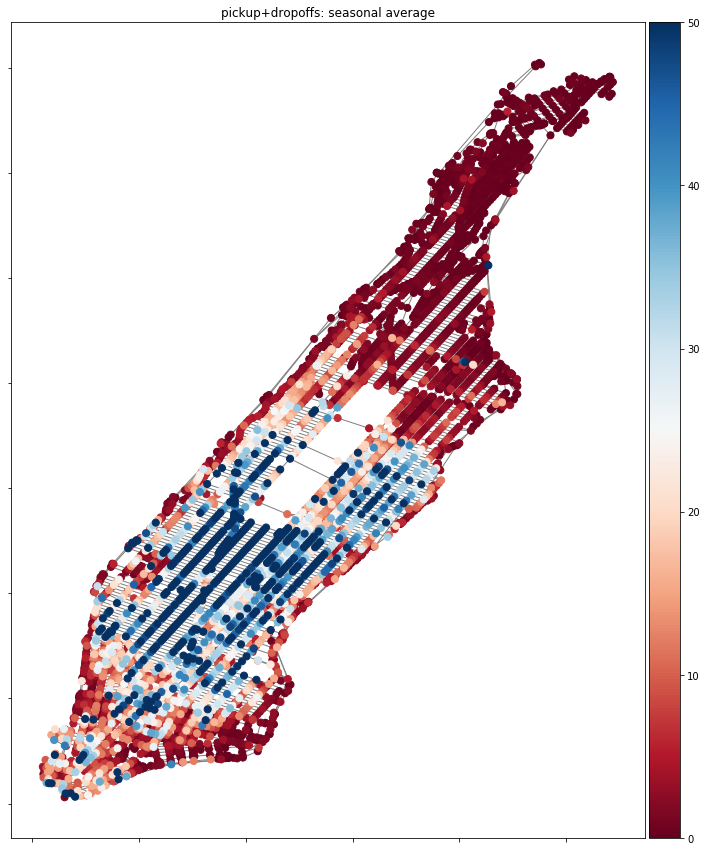

In [16]:
figsize = (12, 15)
logbool = False
sig_season = np.array(list(nx.get_node_attributes(G,'sig_season').values()))
plot_nyc_signal(G_pg, sig_season, name='seasonal average', normalize=False, absolute=False, log=logbool, figsize=figsize, limits=[0,50],colorbar=True)

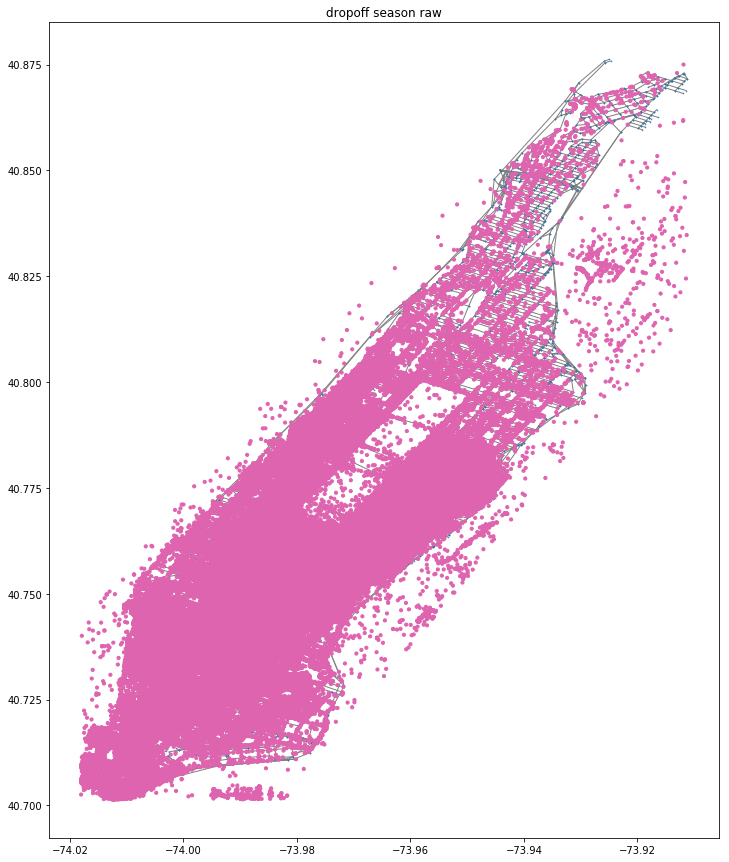

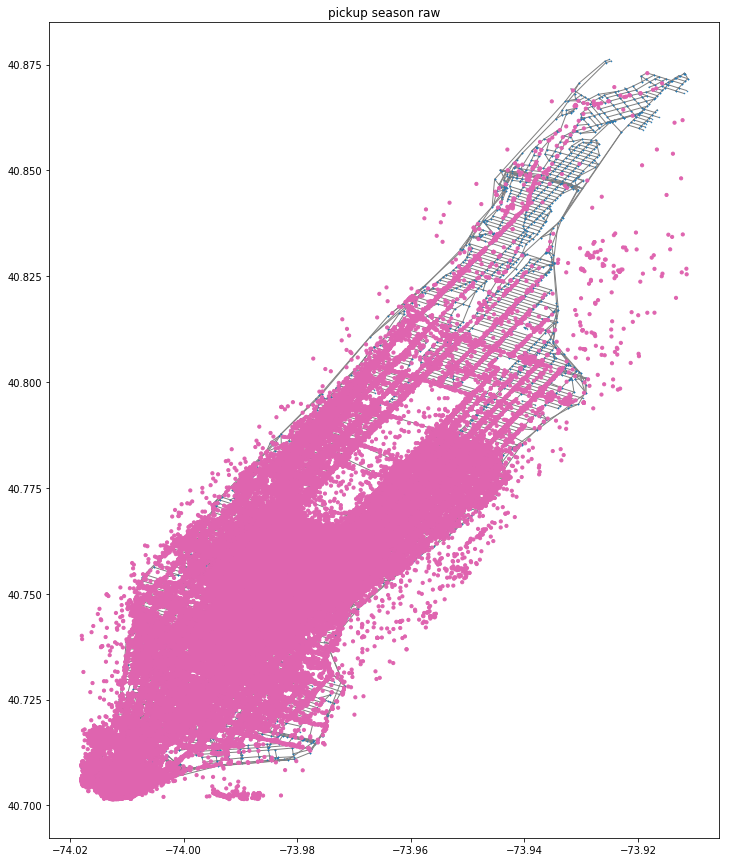

In [17]:
coords = np.array(season_dropoff[["dropoff_longitude", "dropoff_latitude"]])
plot_nyc_raw_signal(G_pg, len(season_dropoff.index)*[1], coords, name='dropoff season raw', normalize=False, absolute=False, log=logbool, figsize=figsize, limits=[0,2],colorbar=False)
coords = np.array(season_pickup[["pickup_longitude", "pickup_latitude"]])
plot_nyc_raw_signal(G_pg, len(season_pickup.index)*[1], coords, name='pickup season raw', normalize=False, absolute=False, log=logbool, figsize=figsize, limits=[0,2],colorbar=False)

# Plotting season average - sig event 

In [18]:
sig_event = nx.get_node_attributes(G,'sig_event')
sig_season = nx.get_node_attributes(G,'sig_season')
sig_dict = {key: sig_event[key] - sig_season[key] for key in G.nodes()}
nx.set_node_attributes(G,sig_dict,'y_sig')

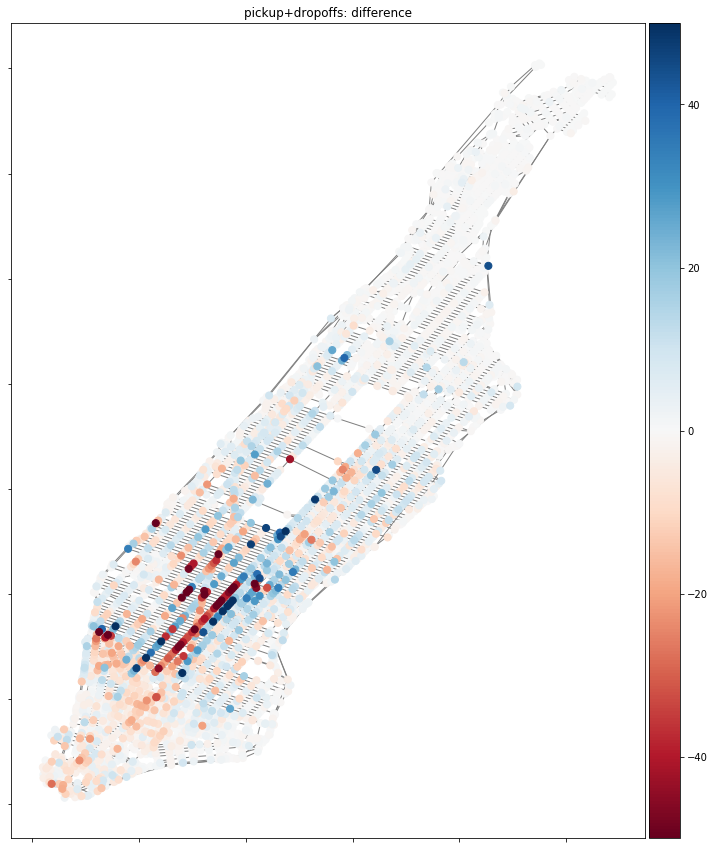

In [19]:
figsize = (12, 15)
logbool = False
y_sig = np.array(list(nx.get_node_attributes(G,'y_sig').values()))
plot_nyc_signal(G_pg, y_sig, name='difference', normalize=False, absolute=False, log=logbool, figsize=figsize, limits=[-50,50],colorbar=True)

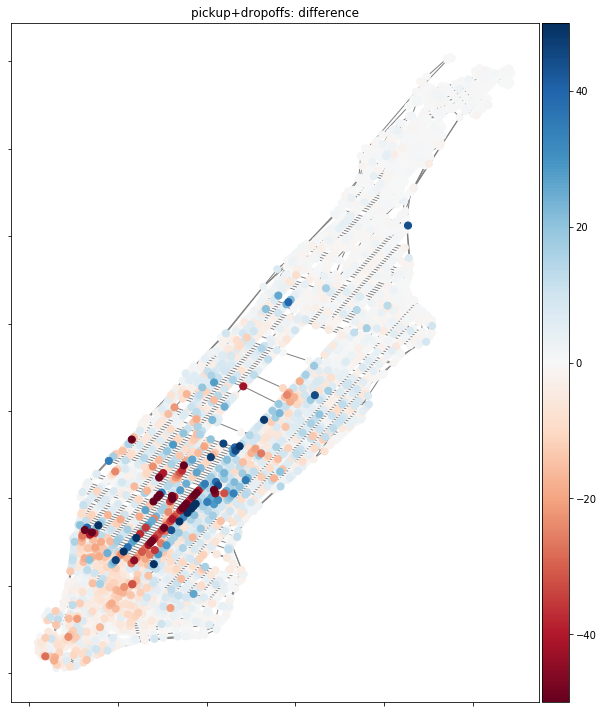

In [20]:
figsize = (10, 12.5)
logbool = False
y_sig = np.array(list(nx.get_node_attributes(G,'y_sig').values()))
fig = plot_nyc_signal(G_pg, y_sig, name='difference', normalize=False, absolute=False, log=logbool, figsize=figsize, limits=[-50,50],colorbar=True)
plt.savefig('nyc_raw_signal.pdf',bbox_inches='tight')



# Pride events where traffic was shut off

In [21]:
# Based on 2011 Pride Guide magazine by NYC Pride
# https://issuu.com/nycpride/docs/prideguide_9_rev2_low-res
parade_dict = {'pickup_longitude' : [], 'pickup_latitude': []}

p1 = (-73.982833, 40.752195) # 5th ave, 40th (standby, Bryant park)
p2 = (-73.996403, 40.732239) # 5th ave, 8th 
m = (p2[1]-p1[1])/(p2[0]-p1[0])

for x in np.linspace(p2[0],p1[0],40):
    tmp = m*(x-p1[0]) + p1[1] 
    parade_dict['pickup_latitude'].append(tmp)
    parade_dict['pickup_longitude'].append(x)

p3 = (-73.999691, 40.734054) # 6th ave, Christopher
m = (p3[1]-p2[1])/(p3[0]-p2[0])

for x in np.linspace(p3[0],p2[0],10):
    tmp = m*(x-p2[0]) + p2[1] 
    parade_dict['pickup_latitude'].append(tmp)
    parade_dict['pickup_longitude'].append(x)
    
p4 = (-74.007526, 40.732875) # Christopher, Greenwich
m = (p4[1]-p3[1])/(p4[0]-p3[0])

for x in np.linspace(p4[0],p3[0],15):
    tmp = m*(x-p3[0]) + p3[1] 
    parade_dict['pickup_latitude'].append(tmp)
    parade_dict['pickup_longitude'].append(x)

p5 = (-74.005134, 40.740840) # Hudson, 14th
p6 = (-74.005847, 40.736942) # Hudson, Bethune 
m = (p6[1]-p5[1])/(p6[0]-p5[0])

for x in np.linspace(p6[0],p5[0],20):
    tmp = m*(x-p5[0]) + p5[1] 
    parade_dict['pickup_latitude'].append(tmp)
    parade_dict['pickup_longitude'].append(x)

    
parade = pd.DataFrame(parade_dict)
parade['closest_node'] = get_closest_nodes(G, parade, pickup=True)

parade_sig_event = get_signal_dict(G, parade)
sig_dict = {key: parade_sig_event[key] for key in parade_sig_event.keys()}
nx.set_node_attributes(G,sig_dict,'parade')

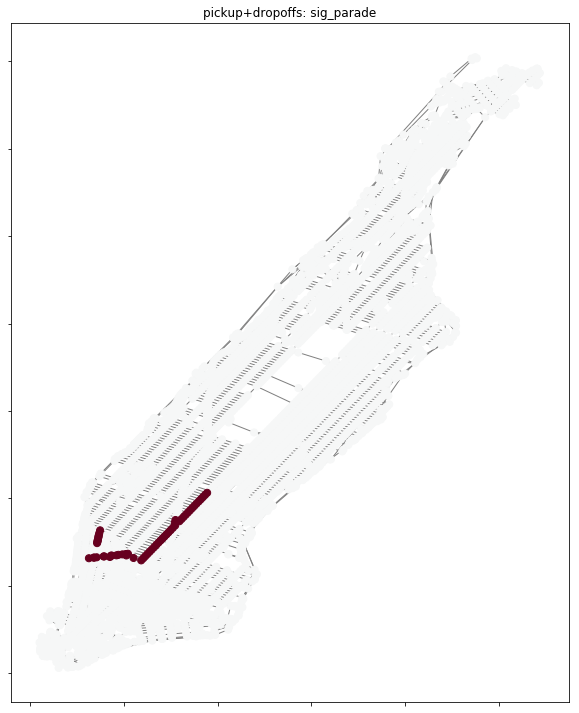

In [22]:
sig_parade = np.array(list(nx.get_node_attributes(G,'parade').values()))

plot_nyc_signal(G_pg, -1*sig_parade, name='sig_parade', normalize=False, absolute=False, log=logbool, figsize=figsize, limits=[-0.1,0.1],colorbar=False)
plt.savefig('nyc_parade.pdf', bbox_inches='tight')

# GTF

In [23]:
tol = 5

In [24]:
Dk = nx.incidence_matrix(G, nodelist=G.nodes(), edgelist=G.edges(), oriented=True, weight='weight').T
DTD = Dk.T.dot(Dk).toarray()
[S, V] = np.linalg.eigh(DTD)

In [25]:
y_sig = np.array(list(nx.get_node_attributes(G,'y_sig').values()))
norm_flag = False
if norm_flag:
    y_sig = y_sig/np.linalg.norm(y_sig,2)
    print(min(y_sig), max(y_sig))
    plot_nyc_signal(G_pg, y_sig, name='difference', normalize=False, absolute=False, log=logbool, figsize=figsize, limits=[-0.1,0.1],colorbar=True)

[-109.37464649] [71.12499958]
[201]


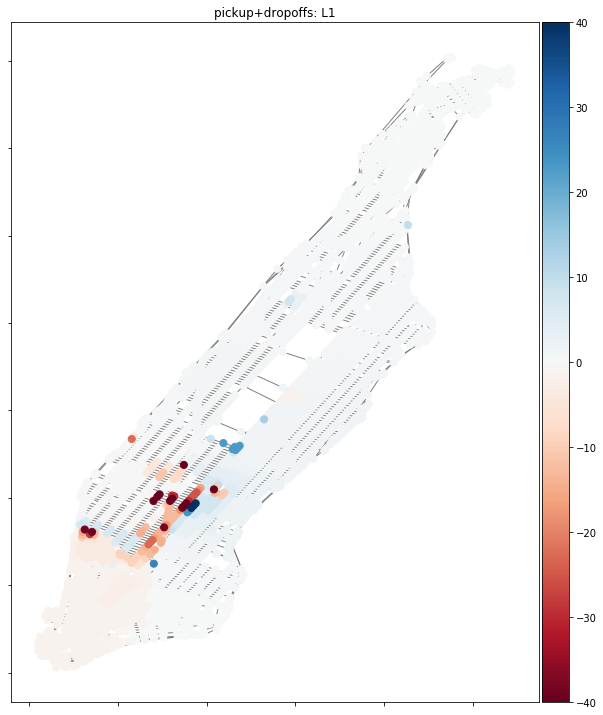

In [26]:
gamma = 11.5
rho = 0.1*gamma

invX = V.dot(np.diag(1/(1+rho*S))).dot(V.T)
l1_beta, obj, err_path = admm(y_sig.reshape(-1,1), gamma, rho, Dk,'L1', 0.0, tol_abs=10**(-4), tol_rel=10**(-3), max_iter=1000, B_init = None, invX=invX)

print(min(l1_beta), max(l1_beta))

figsize = (10, 12.5)
plot_nyc_signal(G_pg, l1_beta.reshape(-1), name='L1', normalize=False, absolute=False, log=False, figsize=figsize, limits=[-40, 40],colorbar=True)
print(sum(abs(Dk*l1_beta)>tol))

plt.savefig('l1_nyc.pdf',bbox_inches='tight')

[-155.37465669] [93.3250602]
[200]


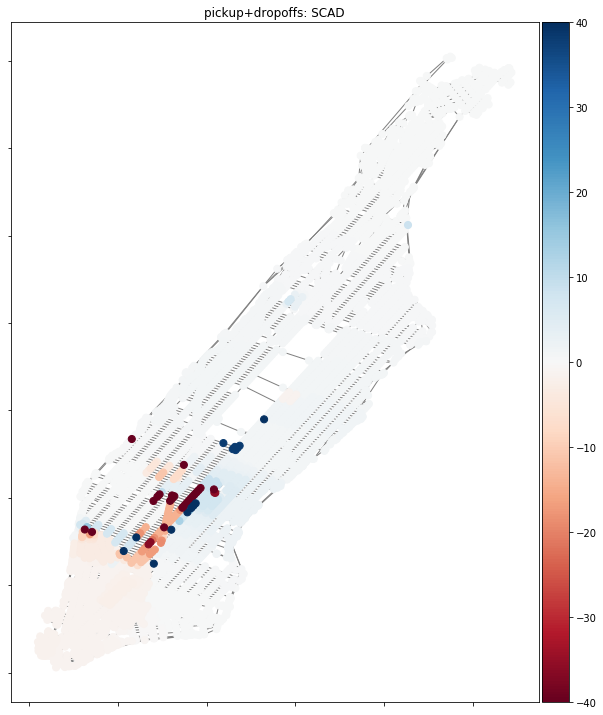

In [27]:
gamma = 11.9
rho = max(0.1*gamma, 1/3.7)
invX = V.dot(np.diag(1/(1+rho*S))).dot(V.T)

scad_beta, obj, err_path = admm(y_sig.reshape(-1,1), gamma, rho, Dk,'SCAD', 3.7, tol_abs=10**(-4), tol_rel=10**(-3), max_iter=1000, B_init = l1_beta, invX=invX)
print(min(scad_beta), max(scad_beta))


figsize = (10, 12.5)
plot_nyc_signal(G_pg, scad_beta.reshape(-1), name='SCAD', normalize=False, absolute=False, log=False, figsize=figsize, limits=[-40, 40],colorbar=True)
print(sum(abs(Dk*scad_beta )>tol))




[-155.29765819] [117.13640644]
[194]


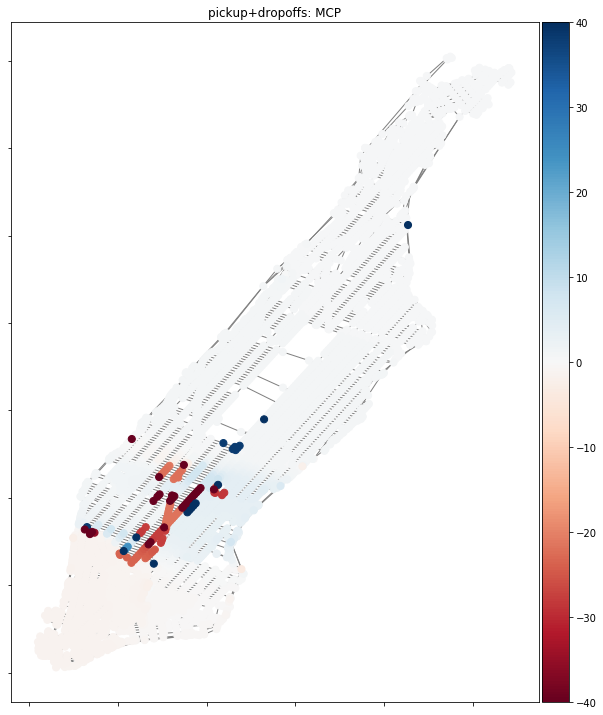

In [28]:
gamma = 25.5
rho = max(0.1*gamma, 1/1.4)
invX = V.dot(np.diag(1/(1+rho*S))).dot(V.T)

mcp_beta, obj, err_path = admm(y_sig.reshape(-1,1), gamma, rho, Dk,'MCP', 1.4, tol_abs=10**(-4), tol_rel=10**(-3), max_iter=1000, B_init = l1_beta, invX=invX)
print(min(mcp_beta), max(mcp_beta))


figsize = (10, 12.5)
plot_nyc_signal(G_pg, mcp_beta.reshape(-1), name='MCP', normalize=False, absolute=False, log=False, figsize=figsize, limits=[-40, 40],colorbar=True)

print(sum(abs(Dk*mcp_beta )>tol))
plt.savefig('MCP_nyc.pdf',bbox_inches='tight')